# Importing Data 

In [4]:
import numpy as np
import math
import os
from scipy import signal
from scipy import optimize
import UDIP_Lib_V19 as UDIP_Lib  #making updating UDIP_Lib easier
import RockSat_1_14_fitting_functions as R_fitting
import json
import matplotlib.pyplot as plt
from RockSat_json import *

In [5]:
year = 2021
#packets = import_data(f'../{year}/{year}_packet.json')
packets = import_data(f'{year}_packet.json')

# Get Sweep and Saving Figures

In [6]:
def get_sweep(sw, cn = 0):

  sec = np.linspace(0, 1, 5)

  start = sw['Start'] / 1000 # convert milliseconds to seconds
  stop =  sw['Stop'] / 1000

  sw['Voltage'] = np.array(sw['Voltage'])
  sw[f'Current{cn}'] = np.array(sw[f'Current{cn}'])

  V1 = sw['Voltage']     [0: int(sec[1] * len(sw['Voltage' ]))]
  I1 = sw[f'Current{cn}'][0: int(sec[1] * len(sw[f'Current1']))]

  V2 = sw['Voltage']     [int(sec[1]*len(sw['Voltage' ]))      :int(sec[2]*len(sw['Current1'])) ]
  I2 = sw[f'Current{cn}'][int(sec[1]*len(sw[f'Current{cn}']))  :int(sec[2]*len(sw['Current1'])) ]

  V3 = sw['Voltage']     [int(sec[2]*len(sw['Voltage' ]))      :int(sec[3]*len(sw['Current1'])) ]
  I3 = sw[f'Current{cn}'][int(sec[2]*len(sw[f'Current{cn}']))  :int(sec[3]*len(sw['Current1'])) ] 

  V4 = sw['Voltage']     [int(sec[3]*len(sw['Voltage' ]))      :int(sec[4]*len(sw['Current1'])) ]
  I4 = sw[f'Current{cn}'][int(sec[3]*len(sw[f'Current{cn}']))  :int(sec[4]*len(sw['Current1'])) ]

  Vf = sw['Voltage']     [int(sec[1]*len(sw['Voltage' ]))      :int(sec[3]*len(sw['Current1'])) ]
  If = sw[f'Current{cn}'][int(sec[1]*len(sw[f'Current{cn}']))  :int(sec[3]*len(sw['Current1'])) ]
  return start, stop, V1, I1, V2, I2, V3, I3, V4, I4

# Generate Sweep Images - Every 100

In [4]:
sw_range = np.arange(0,int(len(packets['packets']['Medium'])), 100) 

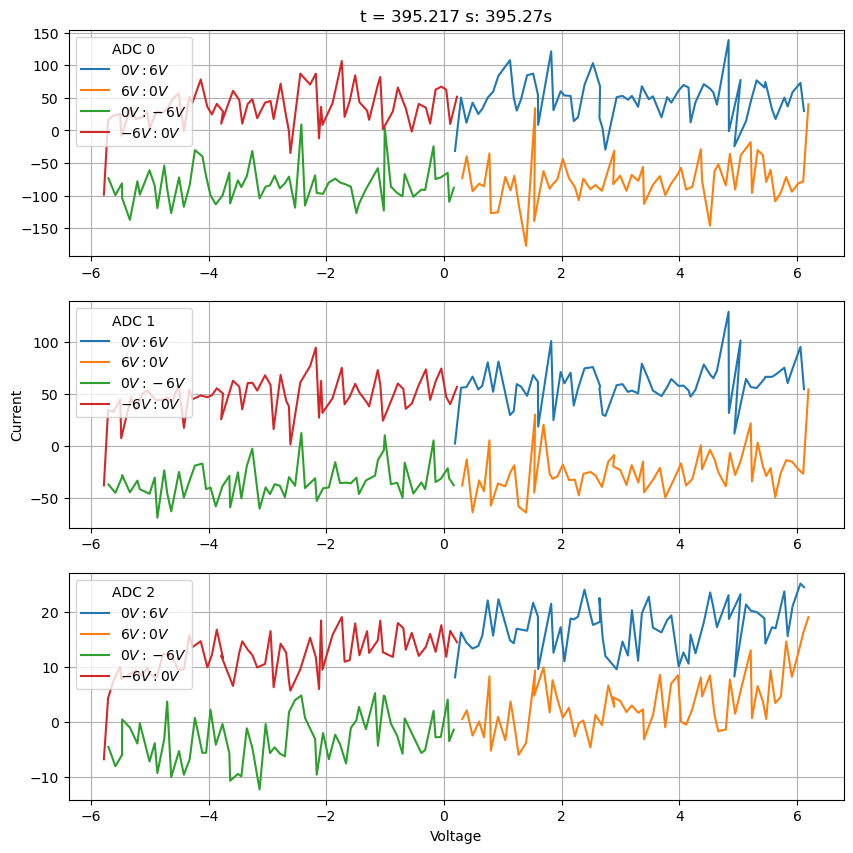

In [5]:
cn = 0
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i in sw_range:
  for axnum in np.arange(len(axs)):
    axs[axnum].clear()
    cn = axnum
    start, stop, V1, I1, V2, I2, V3, I3, V4, I4 = get_sweep(packets['packets']['Medium'][f'{i}'], cn = cn)

    axs[axnum].plot(V1, I1 , label = r'$ 0V : 6V$')
    axs[axnum].plot(V2, I2 , label = r'$ 6V:  0V$')
    axs[axnum].plot(V3, I3 , label = r'$ 0V: -6V$')
    axs[axnum].plot(V4, I4 , label = r'$-6V : 0V$')
    axs[axnum].legend(title = f'ADC {cn}', loc = 'upper left')
    axs[axnum].grid()
  axs[0].set_title(f't = {start} s: {stop}s')
  axs[2].set_xlabel('Voltage')
  axs[1].set_ylabel('Current')
  #plt.savefig(f'../{year}/Sweeps/sw_{i}.jpg' , dpi = 400) 

# Plot a Single Sweep

In [6]:
sweepNum = 1000
fp = getFloatingPotential(sweepNum)
plsm = getPlasmaPotential(sweepNum)
cn = 0
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for axnum in np.arange(len(axs)):
    axs[axnum].clear()
    cn = axnum
    start, stop, V1, I1, V2, I2, V3, I3, V4, I4 = get_sweep(packets['packets']['Medium'][f'{sweepNum}'], cn = cn)

    axs[axnum].plot(V1, I1 , label = r'$ 0V : 6V$')
    axs[axnum].plot(V2, I2 , label = r'$ 6V:  0V$')
    axs[axnum].plot(V3, I3 , label = r'$ 0V: -6V$')
    axs[axnum].plot(V4, I4 , label = r'$-6V : 0V$')
    axs[axnum].legend(title = f'ADC {cn}', loc = 'upper left')
    axs[axnum].grid()
axs[0].axvline(x = fp, linestyle = '--', color = 'firebrick', label = 'est. Floating Potential')
axs[0].axvline(x = plsm, linestyle = '--', color = 'skyblue', label = 'est. Plasma Potential')
axs[0].legend(title = f'ADC 0', loc = 'upper left')
axs[0].set_title(f'Sweep {sweepNum} (t = {start} - {stop}s)')
axs[2].set_xlabel('Voltage')
axs[1].set_ylabel('Current')
#plt.savefig(f'../{year}/Sweeps/sw_{i}.jpg' , dpi = 400) 

NameError: name 'getFloatingPotential' is not defined

# Objectives

Use gen fit 
 * popt = optimize parameters
  t is x, y is model 
extract popt  it will be an array of values array of values
* (Around 30)
Plot it to check to see if you have a good fit 

**Note**: Use Sweeps 1000 - 1900 as they show the best IV curves

* x, y, popt, pcov = genfit(V, I)
    * x and y will be your fitted IV curve
    * popt is an array of m, b ,and a
* look at electron saturation region eq, inside equation is B, get Te from that since everything is a constant besdies Te
* Look at line 44 in rock sat fitting functions 

Use log linear fit for voltage instead of normal linear fit

_Q_: What are the units for the output?
* T is in Kelvin
* n is in m^3

# Fitting Functions

In [ ]:
def jarrod_fit(sweepNum):
    V = packets['packets']['Medium'][f'{sweepNum}']['Voltage']
    I = packets['packets']['Medium'][f'{sweepNum}']['Current0']
    x_raw, y_raw = np.array(V), np.array(I)
    x,y = data_processing(x_raw,y_raw)
    # x,y = R_fitting.data_processing(x_raw,y_raw)
    # g = [0.6,-14,80, 5*(10**10),1000,-0.5]    #intial guess
    #change 10000 to something lower for temperature bounds
    b = ((-3, -3, -np.inf, -np.inf, 0, 0, -3, -3), (3, 3, np.inf, np.inf, np.inf, 10000, 3, 3))  # bounds
    popt, pcov = optimize.curve_fit(model, x, y, p0=[0.6,0.8,-14,80, 5*(10**10),1000,-0.5,-0.5], bounds=b)
    
    t = np.linspace(min(x), max(x), num=264)
    return t, model(t,*popt),popt,pcov #popt[0:fp,1:plsm,2:offset,3:ionSlope,4:n,5:temp,6:V0,7:Vp]

def printIVAnalysis(sweepNum):
    x, y, popt, pcov = jarrod_fit(sweepNum) # x is V, y is I
    fp, plsm, offset, ionSlope, n, temp, V0, Vp = popt
    print(f'popt = {popt}')
    print('')
    print(f'The floating potential is {round(fp, 3)} V.')
    print(f'The plasma potential is {round(plsm, 3)} V.')
    print(f'The current offset is {round(offset, 3)} nA.')
    print(f'The ion saturation slope is {round(ionSlope, 3)}.')
    print(f'The electron density is {round(n, 3)} cm^(-3).')
    print(f'The electron temperature is {round(temp, 3)} K.')
    print(f'The voltage offset is {round(V0, 3)} V.')
    print('')

In [ ]:
def model(x, xf, xp, b, m1, n, t, V0, Vp):
    # changed to be hopefully more efficient
    ret = np.zeros(len(x))
    for i in range(0, len(x)):
        if(x[i] <= xf):
            ret[i] = seg1(x[i], m1) - seg1(xf, m1) + b
        # Something wrong with this part, messes up the fit ##################################################
        elif(xf < x[i] <= xp):
            ret[i] = seg2(x[i], n, t, Vp) - seg2(xf, n, t, Vp) + seg1(xf, m1) - seg1(xf, m1) + b
        ######################################################################################################
        elif(x[i] > xp):
            ret[i] = seg3(x[i], n, t, V0) - seg3(xp, n, t, V0) + seg1(xp, m1) - seg1(xp, m1) + b
        
    # ret[x <= xf] = seg1(x[x <= xf], m1) - seg1(xf, m1) + b
    # ret[x > xp] = seg3(x[x > xp], n, t, V0) - seg3(xp, n, t, V0) + seg1(xp, m1) - seg1(xp, m1) + b
    # ret[xf < x <= xp] = seg2(x[xf < x <= xp], n, t, Vp) - seg2(xf, n, t, Vp) + seg1(xf, m1) - seg1(xf, m1) + b
    return ret

In [ ]:
def seg1(x, m):  # linear--ion saturation
    return m * x

def seg2(x,n,t,Vp):  # exponential -- electron transition region
    q_e = 1.602 * 10 ** -19  # C                charge of an electron
    K_b = 1.381 * 10 ** -23  # m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10 ** -31  # kg               mass of an electron
    R = (3. / 16.) * 0.0254  # radius of probe
    L = (3.25) * 0.0254  # length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2)  # area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I_therm = n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10 ** -9)
    return I_therm * math.exp(k * (x - Vp))

def seg3(x, n, t, V0):  # square root
    q_e = 1.602 * 10 ** -19  # C                charge of an electron
    K_b = 1.381 * 10 ** -23  # m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10 ** -31  # kg               mass of an electron
    R = (3. / 16.) * 0.0254  # radius of probe
    L = (3.25) * 0.0254  # length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2)  # area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I0 = n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10 ** -9)
    return I0 * np.sqrt(1. + k * (x + V0))

# Better Fitting Functions

In [7]:
def gen_fit(V_arr, I_arr, proc = False):
    V_proc = []
    I_proc = []
    if proc == True:
        V_proc, I_proc = data_processing(V_arr, I_arr)
    else:
        V_proc, I_proc = V_arr, I_arr
    guess = [0.3, 0.9, 100, 80,  2,  8*(10**10), 1000]    #intial guess
    b = ((0, 0.5, -1000,-100, 0, 0, 0),(0.5, 1.5, 1000,100, 100, np.inf,10000)) #bounds

    popt, pcov = optimize.curve_fit(model, V_proc, I_proc, guess, bounds = b)
    # popt, pcov = curve_fit(model, V_proc, I_proc)
    V_fit = np.linspace(min(V_proc),max(V_proc), num = 300) #Voltage array processed for fit
    return V_fit, model(V_fit,*popt), popt, pcov

def model(V_proc, Vf, VP, m1, b, a, ne, etemp):
    I_fit = np.zeros(len(V_proc))
    #Linear fit for ion saturation
    I_fit[V_proc <= Vf] = lin_fit(V_proc[V_proc <= Vf], m1, b)
    I1_cont =  -(exp_fit(Vf, a, etemp, Vf) + lin_fit(Vf, m1, b))
    #Exp fit for transition region
    I_fit[(V_proc > Vf) & (V_proc <= VP)] = exp_fit(V_proc[(V_proc > Vf) & (V_proc <= VP)], a, etemp,  Vf) + I1_cont
    I2_cont = -(exp_fit(VP, a, etemp,  Vf) + I1_cont)
    #Sqrt fit for electron saturation
    I_fit[V_proc > VP] = sqrt_fit(V_proc[V_proc > VP], ne, etemp ,VP) + I2_cont
    return I_fit

def lin_fit(x, m, y_int): #linear--full model square root
    return m * x + y_int

def exp_fit(x, a, etemp, Vf): #exponential fit
    q_e = 1.602 * 10**-19 #electron charge [C]
    K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
    k = q_e / (K_b * etemp)
    return a * np.exp(k * (x - Vf))

def sqrt_fit(x, ne, etemp, VP):# square root
    q_e = 1.602 * 10**-19 #electron charge [C]
    K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
    m_e = 9.109 * 10**-31 #electron mass [kg]              
    R = (3./16.) * 0.0254 #radius of probe [cm?]
    L = (3.25) * 0.0254 #length of probe [cm?]
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #top and length area of cylinder [cm^2]

    k = q_e / (K_b * etemp)
    I0 = ne * q_e * np.sqrt(K_b * etemp / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1. + k*(x - VP))

In [8]:
def data_processing(V, I):
    Imax = np.argmax(I) #find index of maximum Current
    if (Imax.size != 1):
        Vmin_Imax = np.argmin(V[Imax]) #find lowest voltage value with max current
    else:
        Vmin_Imax = Imax
    # ///////////////////////////////////////////////////
    V_proc = []
    I_proc = []
    for i in range(0,len(V)):
        if ((V[i] > -3) & (V[i] < V[Vmin_Imax])):
            V_proc.append(V[i])
            I_proc.append(I[i])
    # ///////////////////////////////////////////////////
    # V_rem = (V > -3) & (V < V[Vmin_Imax]) #array of voltages > -3V and < Vmin_Imax
    # V_proc = V[V_rem]
    # I_proc = I[V_rem]
    return V_proc, I_proc

In [9]:
def getFloatingPotential(V, I):
    V_pros, I_pros = data_processing(V, I)
    x, y, popt, pcov = gen_fit(V_pros, I_pros, True) # x is V, y is I
    print(f'The estimated floating potential is {round(popt[0], 3)} V.')
    return popt[0]

def getPlasmaPotential(V, I):
    V_pros, I_pros = data_processing(V, I)
    x, y, popt, pcov = gen_fit(V_pros, I_pros, True) # x is V, y is I
    print(f'The estimated plasma potential is {round(popt[1], 3)} V.')
    return popt[1]

# Misc Functions

In [10]:
def num_list(x, y, num_points): #num_points >= 1
    nx = x[:: int(math.ceil(265 / num_points)) ]    #math.ciel() function rounds up to the nearest integer
    ny = y[:: int(math.ceil(265 / num_points)) ]
    
    return nx, ny #new x and new y (smaller list)

def cut_list(mylist, frac):
    if (1/frac)%1 == 0.0:  #If the fraction has a 1 in the numerator (easier steps)
        step = int(1/frac)
        new_list = mylist[ :: step]
        return new_list
 
    elif (1/frac)%1 != 0.0: # If the fraction has anything other than 1 in the numerator (more complicated steps)
        num_pts = int(len(mylist) - len(mylist)*frac)
        step = int(len(mylist) / num_pts)
        new_list = mylist[::] #New list that won't interfere with the value of the og list
 
        del new_list[::step]  #deleting specific steps from the new_list
        return new_list

In [11]:
def pts_count(x, y):
    count = 0
    for i in range(0, len(x)):
        if(x[i] < y):
            count += 1
    return count


def lin_sqrt_sample(V, I, Vf, lin_frac, sqrt_frac):  # "Use [frac] of the points from the original list"
    
    V_new = []
    I_new = []
    
    lin_points = pts_count(V, Vf)
    print(f'There are {lin_points} points in V below the floating potential, out of {len(V)}')
    
    sqrt_points = len(V) - lin_points
    print(f'There are {sqrt_points} points in V above the floating potential, out of {len(V)}')
    
    lin_steps = int(math.ceil(lin_points / (lin_points * lin_frac)))
    print(f'The Linear section will sample every {lin_steps} points')
    
    sqrt_steps = int(math.ceil(sqrt_points / (sqrt_points * sqrt_frac)))
    print(f'The Square Root section will sample every {sqrt_steps} points')
    
    for i in range (0, len(V)):
        if (V[i] < Vf):  # Linear Portion
            if (i % lin_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
        elif (V[i] >= Vf):  # Square root Portion
            if (i % sqrt_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
    
    return V_new, I_new


def lin_exp_sqrt_sample(V, I, Vf, Vp, lin_frac, exp_frac, sqrt_frac):  # "Use [frac] of the points from the original list"
    
    V_new = []
    I_new = []
    
    lin_points = pts_count(V, Vf)
    print(f'There are {lin_points} points in V below the floating potential, out of {len(V)}')
    
    sqrt_points = len(V) - pts_count(V, Vp)
    print(f'There are {sqrt_points} points in V above the plasma potential, out of {len(V)}')
    
    exp_points = len(V) - lin_points - sqrt_points
    print(f'There are {exp_points} points in V between the floating and plasma potentials, out of {len(V)}')
    
    lin_steps = int(math.ceil(lin_points / (lin_points * lin_frac)))
    print(f'The Linear section will sample every {lin_steps} points')
    
    sqrt_steps = int(math.ceil(sqrt_points / (sqrt_points * sqrt_frac)))
    print(f'The Square Root section will sample every {sqrt_steps} points')
    
    exp_steps = int(math.ceil(exp_points / (exp_points * exp_frac)))
    print(f'The Exponential section will sample every {exp_steps} points')
    
    for i in range (0, len(V)):
        if (V[i] < Vf):  # Linear Portion
            if (i % lin_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
        elif (V[i] >= Vp):  # Square root Portion
            if (i % sqrt_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
        elif ((V[i] >= Vf) & (V[i] < Vp)):  # Exponential Portion
            if (i % exp_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
    
    return V_new, I_new
            

# Fitting a Single Sweep

In [13]:
sweepNum = 1000  # Use Sweep 1000 to 1800 

In [12]:
# x, y, popt, pcov = R_fitting.gen_fit(np.array(V), np.array(I)) # x is V, y is I
x, y, popt, pcov = jarrod_fit(sweepNum) # x is V, y is I

printIVAnalysis(sweepNum)

NameError: name 'jarrod_fit' is not defined

The estimated floating potential is 0.28 V.
The estimated plasma potential is 0.774 V.
There are 75 points in V below the floating potential, out of 162
There are 87 points in V above the floating potential, out of 162
The Linear section will sample every 10 points
The Square Root section will sample every 2 points


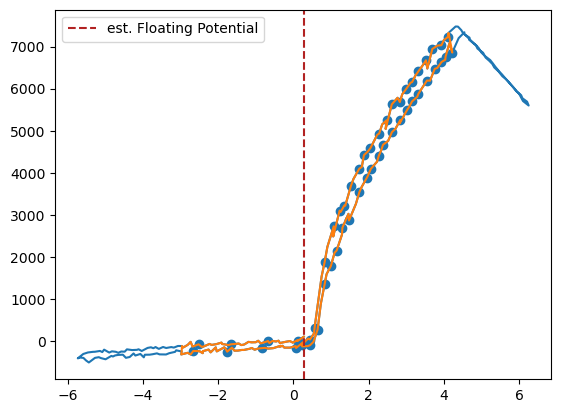

There are 75 points in V below the floating potential, out of 162
There are 77 points in V above the plasma potential, out of 162
There are 10 points in V between the floating and plasma potentials, out of 162
The Linear section will sample every 10 points
The Square Root section will sample every 2 points
The Exponential section will sample every 1 points


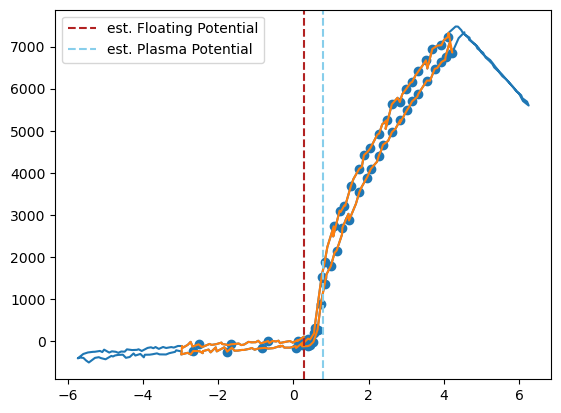

In [12]:
V = packets['packets']['Medium'][f'{sweepNum}']['Voltage']
I = packets['packets']['Medium'][f'{sweepNum}']['Current0']

fp = getFloatingPotential(V, I)
plsm = getPlasmaPotential(V, I)

x,y = data_processing(V,I)


#nx, ny = num_list(x,y,50)

#nx = cut_list(x,(1/4))
#ny = cut_list(y,(1/4))

nx, ny = lin_sqrt_sample(x, y, fp, (1/10), (1/2))

plt.plot(V,I)
plt.plot(x,y)
plt.scatter(nx,ny)

plt.axvline(x = fp, linestyle = '--', color = 'firebrick', label = 'est. Floating Potential')
# plt.axvline(x = plsm, linestyle = '--', color = 'skyblue', label = 'est. Plasma Potential')
plt.legend()
plt.show()


nx, ny = lin_exp_sqrt_sample(x, y, fp, plsm, (1/10), 1, (1/2))

plt.plot(V,I)
plt.plot(x,y)
plt.scatter(nx,ny)

plt.axvline(x = fp, linestyle = '--', color = 'firebrick', label = 'est. Floating Potential')
plt.axvline(x = plsm, linestyle = '--', color = 'skyblue', label = 'est. Plasma Potential')
plt.legend()
plt.show()

In [26]:
V = packets['packets']['Medium'][f'{sweepNum}']['Voltage']
I = packets['packets']['Medium'][f'{sweepNum}']['Current0']

fp = getFloatingPotential(V, I)
plsm = getPlasmaPotential(V, I)




V_pros, I_pros = data_processing(V,I)

x, y, popt, pcov = gen_fit(V_pros, I_pros, True) # x is V, y is I

# ne -> popt[5], temp e -> popt[6]
ne = popt[5]
temp_e = popt[6]

print(f'Electron density fit (all {len(V_pros)} points) = {"{:.4e}".format(ne)} particles/cubic meter')
print(f'Electron temperature fit (all {len(V_pros)} points) = {round(temp_e, 3)} K')
print('')




nx, ny = lin_sqrt_sample(V_pros, I_pros, fp, (1/5), (9/10))

x, y, popt, pcov = gen_fit(nx, ny, True) # x is V, y is I

# ne -> popt[5], temp e -> popt[6]
ne = popt[5]
temp_e = popt[6]

print(f'Electron density fit (sample of {len(nx)} points out of {len(V_pros)}) = {"{:.4e}".format(ne)} particles/cubic meter')
print(f'Electron temperature fit (sample of {len(nx)} points out of {len(V_pros)}) = {round(temp_e, 3)} K')
print('')




nx, ny = lin_exp_sqrt_sample(V_pros, I_pros, fp, plsm, (1/5), (1/1), (9/10))

x, y, popt, pcov = gen_fit(nx, ny, True) # x is V, y is I

# ne -> popt[5], temp e -> popt[6]
ne = popt[5]
temp_e = popt[6]

print(f'Electron density fit (sample of {len(nx)} points out of {len(V_pros)}) = {"{:.4e}".format(ne)} particles/cubic meter')
print(f'Electron temperature fit (sample of {len(nx)} points out of {len(V_pros)}) = {round(temp_e, 3)} K')

The estimated floating potential is 0.28 V.
The estimated plasma potential is 0.774 V.
Electron density fit (all 162 points) = 6.1489e+10 particles/cubic meter
Electron temperature fit (all 162 points) = 1056.902 K

There are 75 points in V below the floating potential, out of 162
There are 87 points in V above the floating potential, out of 162
The Linear section will sample every 5 points
The Square Root section will sample every 2 points
Electron density fit (sample of 59 points out of 162) = 5.6931e+10 particles/cubic meter
Electron temperature fit (sample of 59 points out of 162) = 812.661 K

There are 75 points in V below the floating potential, out of 162
There are 77 points in V above the plasma potential, out of 162
There are 10 points in V between the floating and plasma potentials, out of 162
The Linear section will sample every 5 points
The Square Root section will sample every 2 points
The Exponential section will sample every 1 points
Electron density fit (sample of 65 po